In [1]:
import pyreadr
import scanpy as sc
import numpy as np
import os
import pandas as pd
import anndata as ad
import scrublet as scr
from pathlib import Path

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

In [2]:
# where to save the file and filename to give
DIR2SAVE = Path("/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/20mt/scrublet_qc/")
scrublet_filename = "Che2021_CRC_scrublet.txt"

# figures path to save
FIG2SAVE = DIR2SAVE.joinpath("figures/")
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

In [3]:
adata = sc.read_h5ad(
    "/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/raw/Che2021_CRC_raw.h5ad"
)

In [4]:
set(adata.obs.Tissue)

{'CRC'}

In [5]:
set(adata.obs.Patient)

{'COL07', 'COL12', 'COL15', 'COL16', 'COL17', 'COL18'}

### run scrublet per sample and on raw data
* When working with data from multiple samples, run Scrublet on each sample separately. Because Scrublet is designed to detect technical doublets formed by the random co-encapsulation of two cells, it may perform poorly on merged datasets where the cell type proportions are not representative of any single sample.

In [6]:
adata.obs

,Patient,Tissue,Therapy,Cell_type,Cell_subtype,Sample
AAACCTGAGAAACCTA_COL07_CRC,COL07,CRC,naive,Epithelial,Epithelial,COL07_CRC
AAACCTGAGACAATAC_COL07_CRC,COL07,CRC,naive,Myeloid,cDC2,COL07_CRC
AAACCTGAGACGCAAC_COL07_CRC,COL07,CRC,naive,B,B,COL07_CRC
AAACCTGAGCAGATCG_COL07_CRC,COL07,CRC,naive,T/NK/ILC,Treg,COL07_CRC
AAACCTGAGCTATGCT_COL07_CRC,COL07,CRC,naive,NaN,NaN,COL07_CRC
...,...,...,...,...,...,...
TTTGTCAGTGCACCAC_COL18_CRC,COL18,CRC,NAC,B,B,COL18_CRC
TTTGTCAGTTTGACAC_COL18_CRC,COL18,CRC,NAC,B,B,COL18_CRC
TTTGTCATCATACGGT_COL18_CRC,COL18,CRC,NAC,T/NK/ILC,Naive CD4 T,COL18_CRC
TTTGTCATCTCGTTTA_COL18_CRC,COL18,CRC,NAC,Myeloid,TAM MKI67,COL18_CRC


#### Check that the data is raw 

In [7]:
adata.X[1:5, 1:5]

<4x4 sparse matrix of type '<class 'numpy.float32'>'
	with 0 stored elements in Compressed Sparse Row format>

In [8]:
np.max(adata.X)

22428.0

#### run scrublet
scr.scrub_doublets() simulates doublets from the observed data and uses a k-nearest-neighbor classifier to calculate a continuous doublet_score (between 0 and 1) for each transcriptome. The score is automatically thresholded to generate predicted_doublets, a boolean array that is True for predicted doublets and False otherwise.

In [9]:
def run_scrublet(adata, sample_col="Sample", cellbarcode_index_name="level_1"):
    # create dict that stores scrublet results from each sample in adata
    scrublet_dict = {k: None for k in list(set(adata.obs[sample_col]))}

    # run scrublet per sample
    for sample in scrublet_dict.keys():
        print("Sample:", sample)
        adata_tmp = adata[adata.obs[sample_col] == sample].copy()
        scrub = scr.Scrublet(adata_tmp.X)
        (
            adata_tmp.obs["doublet_score"],
            adata_tmp.obs["predicted_doublet"],
        ) = scrub.scrub_doublets()
        scrub.plot_histogram()
        # sc.external.pp.scrublet(adata_tmp)
        scrublet_dict[sample] = adata_tmp.obs[
            ["Sample", "doublet_score", "predicted_doublet"]
        ]
        # sc.external.pl.scrublet_score_distribution(adata_tmp)

    # Put all scores in a single panda dataframe
    scrublet_concat = (
        pd.concat(scrublet_dict, axis=0)
        .reset_index()
        .drop(labels="level_0", axis=1)
        .set_index(cellbarcode_index_name)
    )

    return scrublet_concat

Sample: COL15_CRC
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Could not find library "annoy" for approx. nearest neighbor search
Automatically set threshold at doublet score = 0.58
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 9.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.3%
Elapsed time: 5.4 seconds
Sample: COL16_CRC
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Could not find library "annoy" for approx. nearest neighbor search
Automatically set threshold at doublet score = 0.74
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 1.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.9%
Elapsed time: 4.0 seconds
Sample: COL18_CRC
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Could not find library "annoy" for approx. nearest neighbor se

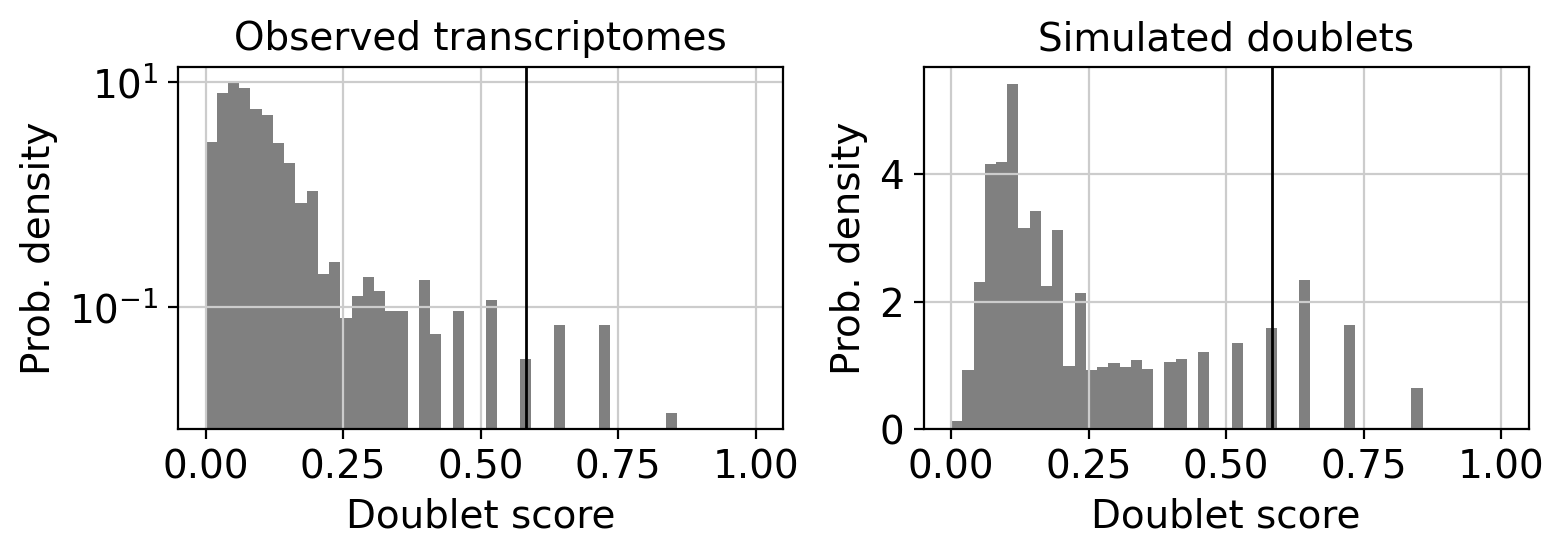

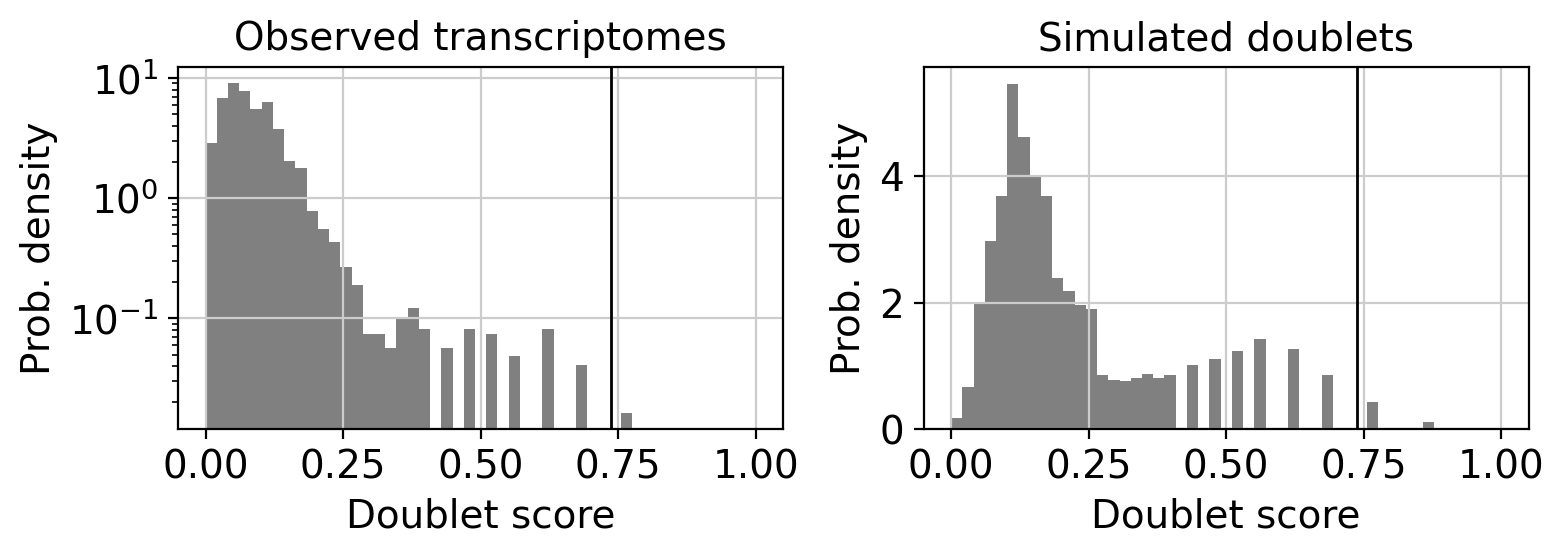

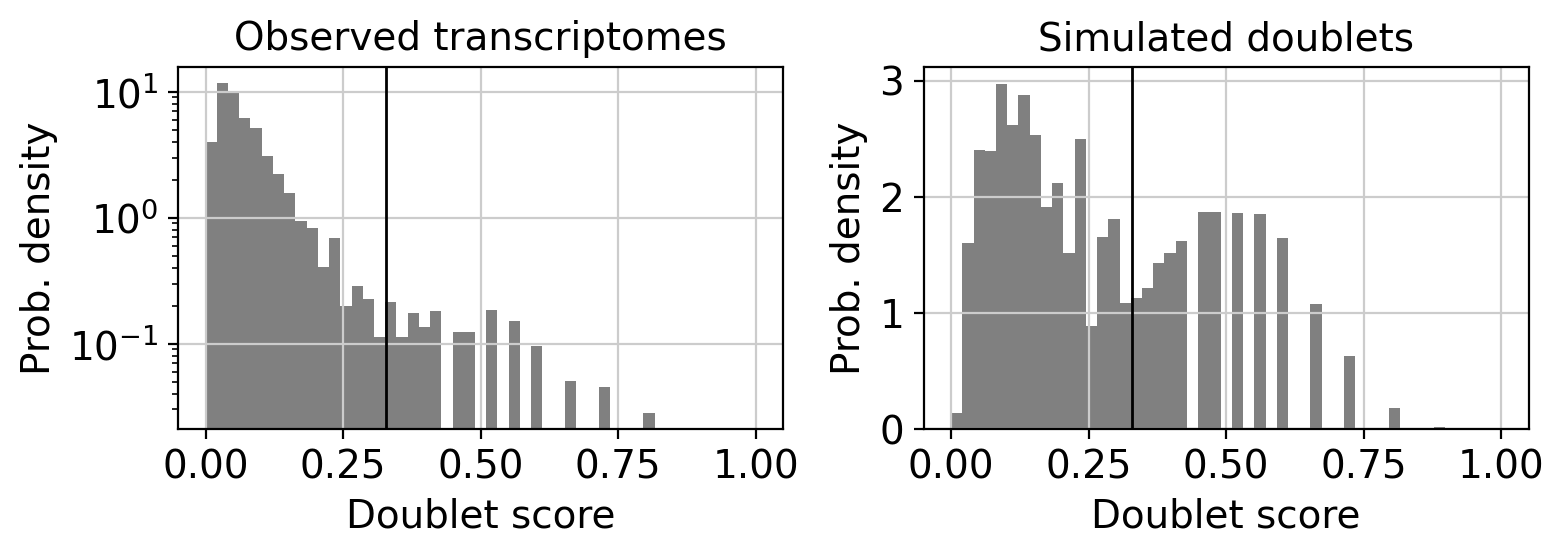

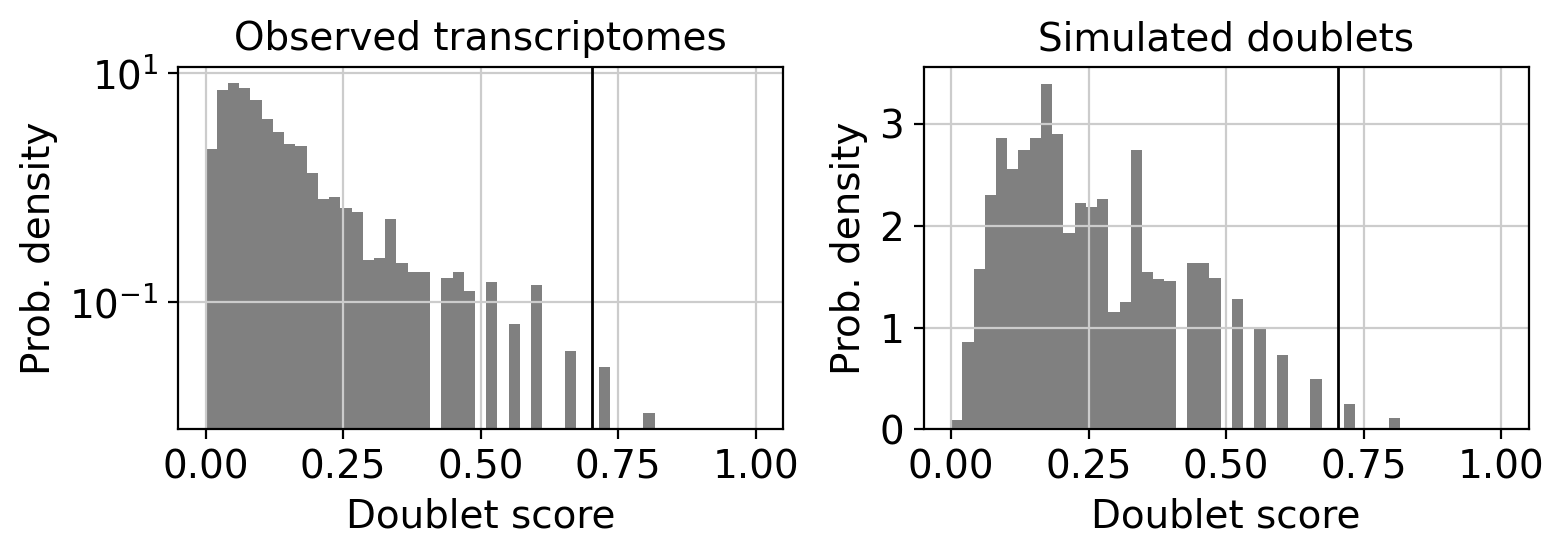

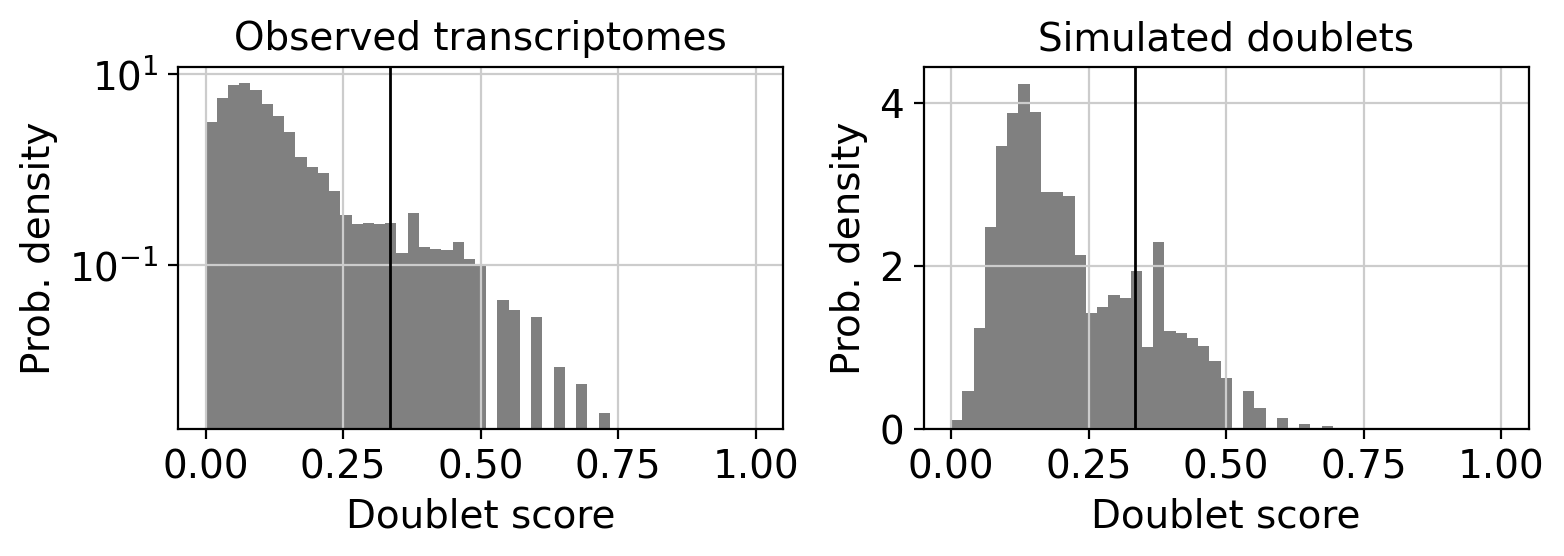

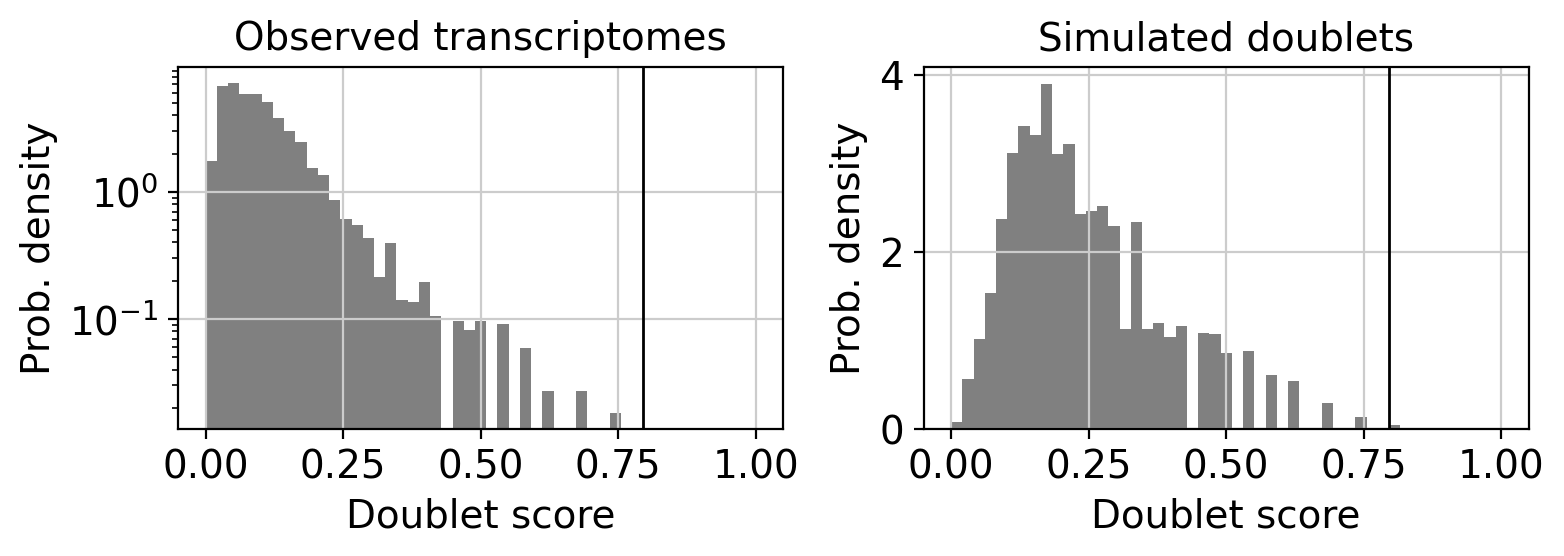

In [10]:
scrublet_concat = run_scrublet(
    adata, sample_col="Sample", cellbarcode_index_name="level_1"
)

In [11]:
scrublet_concat

,Sample,doublet_score,predicted_doublet
level_1,,,
AAACCTGAGCAGACTG_COL15_CRC,COL15_CRC,0.106977,False
AAACCTGCACTAGTAC_COL15_CRC,COL15_CRC,0.106977,False
AAACCTGCAGCGTAAG_COL15_CRC,COL15_CRC,0.121212,False
AAACCTGGTACCGTTA_COL15_CRC,COL15_CRC,0.057797,False
AAACCTGGTCAGAAGC_COL15_CRC,COL15_CRC,0.078105,False
...,...,...,...
TTTGTCATCGCTTAGA_COL12_CRC,COL12_CRC,0.479100,False
TTTGTCATCGGCCGAT_COL12_CRC,COL12_CRC,0.091892,False
TTTGTCATCTCTGCTG_COL12_CRC,COL12_CRC,0.041293,False


In [12]:
print(
    "Number of predicted doublets: ",
    scrublet_concat[scrublet_concat["predicted_doublet"] == True].shape[0],
)

Number of predicted doublets:  860


In [13]:
scrublet_concat.to_csv(
    DIR2SAVE.joinpath(scrublet_filename), sep="\t", index=True, header=True
)

In [14]:
## add scores to adata.obs
# add annot to .obs
adata.obs = adata.obs.merge(
    right=scrublet_concat[["doublet_score", "predicted_doublet"]],
    how="left",
    right_index=True,
    left_index=True,
)

### Quality control

Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.

In [15]:
# find genes that are mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# find genes that are ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

# compute QC metrics
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], inplace=True, log1p=False, percent_top=None
)

In [16]:
print(
    adata.obs[
        ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"]
    ].describe()
)

print(adata.var[["n_cells_by_counts", "total_counts"]].describe())

       n_genes_by_counts   total_counts  pct_counts_mt  pct_counts_ribo
count       55735.000000   55735.000000   55735.000000     55735.000000
mean         1269.656966    5598.198730       6.184313        28.084473
std           985.063551    7566.750488      11.211220        11.709908
min            54.000000     508.000000       0.000000         0.511853
25%           650.000000    1710.000000       2.237930        20.472046
50%           890.000000    2580.000000       3.222342        28.169016
75%          1544.000000    5921.500000       4.865346        35.794579
max          8351.000000  133603.000000      97.575432        83.271378
       n_cells_by_counts  total_counts
count       33694.000000  3.369400e+04
mean         2100.205704  9.260272e+03
std          5494.094803  1.271657e+05
min             0.000000  0.000000e+00
25%             1.000000  1.000000e+00
50%            69.000000  7.500000e+01
75%          1687.000000  2.007750e+03
max         55572.000000  1.155378e+07


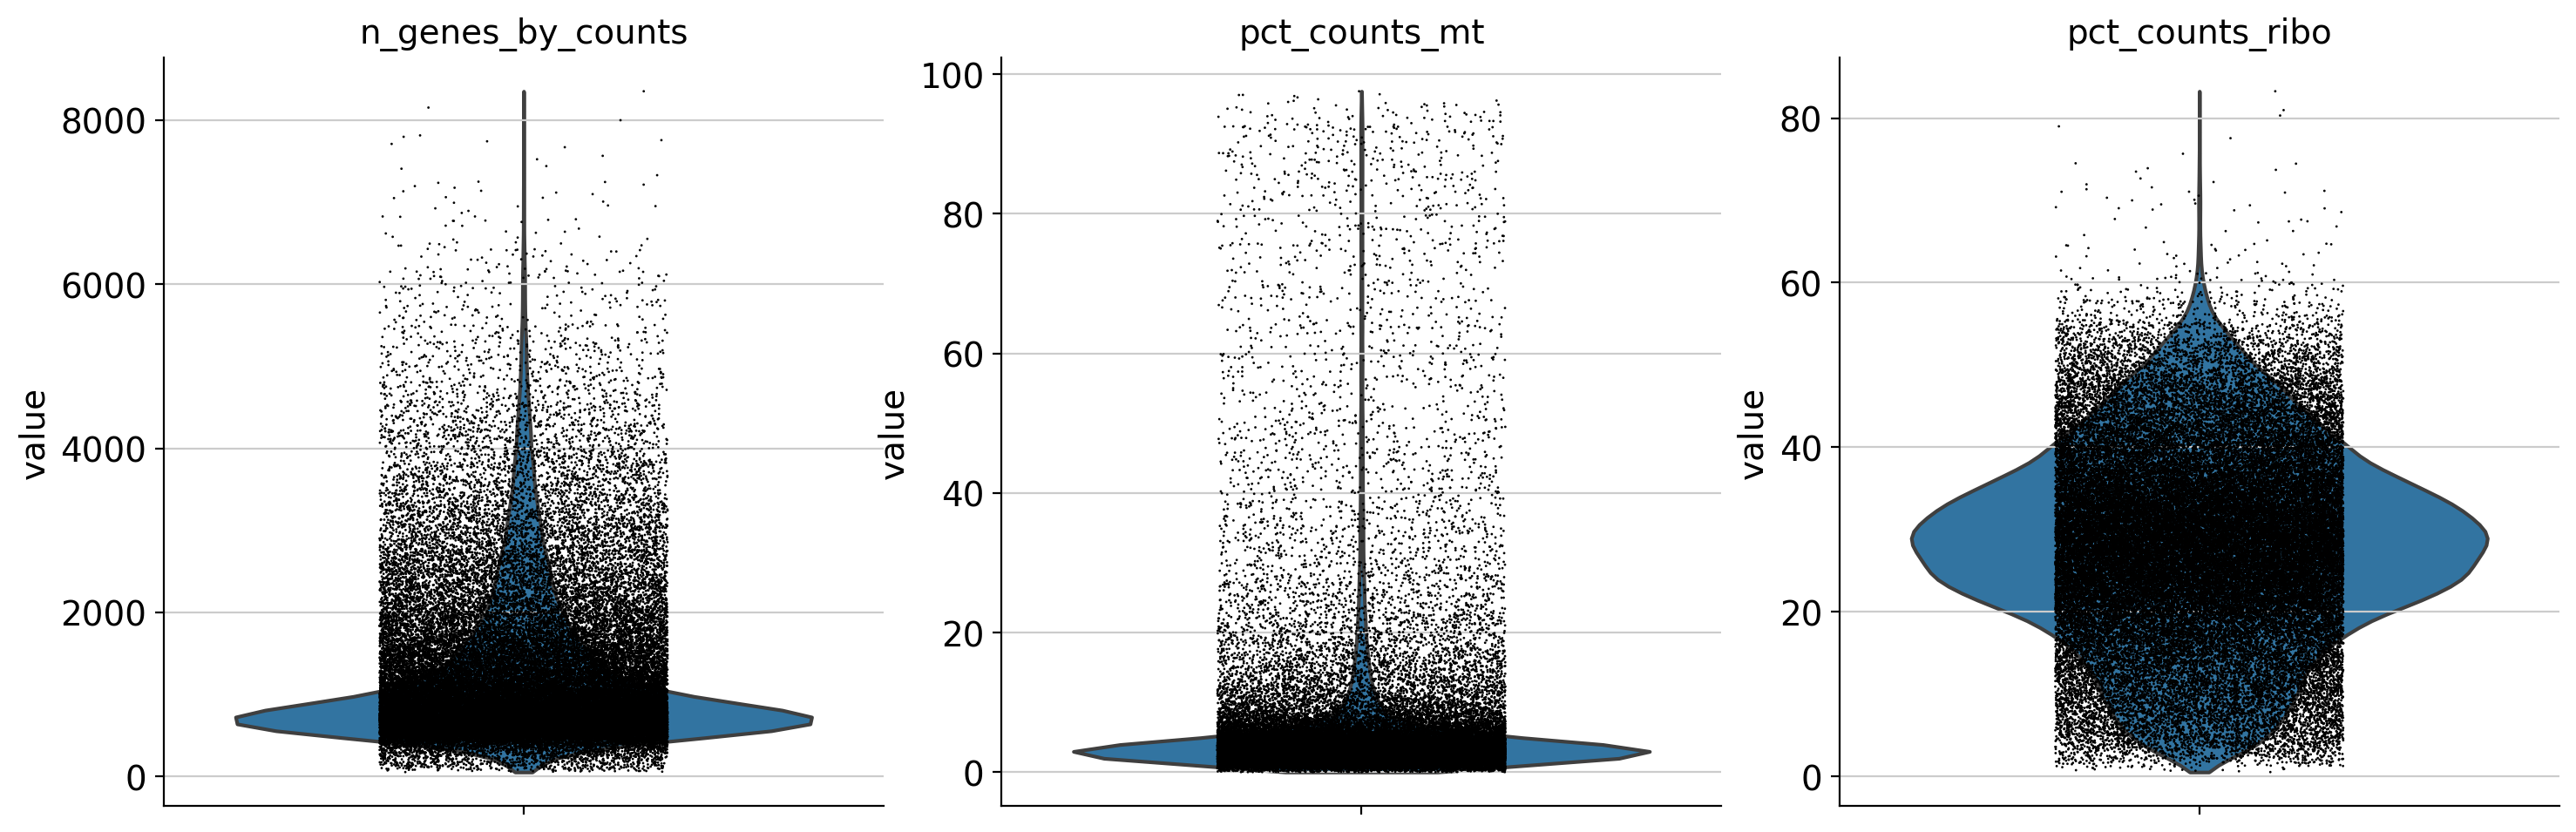

In [17]:
# violin plot of some distributions
sc.pl.violin(
    adata,
    keys=["n_genes_by_counts", "pct_counts_mt", "pct_counts_ribo"],
    jitter=0.2,
    multi_panel=True,
    rotation=30,
    save="Che2021_CRC_QC_covariates.pdf",
    show=True,
)

#### Filter cells according to identified QC thresholds:

* set threshold MT percent to 10%
* remove ribosomal and mitochondrial genes 
* remove cells with less than 300 genes

In [18]:
#### Filter cells according to identified QC thresholds:
print("Total number of cells: {:d}".format(adata.n_obs))

# remove cells with more than 20% MT genes
adata = adata[adata.obs.pct_counts_mt < 20, :].copy()
print("Number of cells after mt filter: {:d}".format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes=300)
print("Number of cells after gene filter: {:d}".format(adata.n_obs))

Total number of cells: 55735
Number of cells after mt filter: 52719
Number of cells after gene filter: 52405


#### Remove mt and ribo genes

In [19]:
print(adata.shape[1])
adata = adata[:, ~adata.var["mt"].values]
print("After mt genes removal: ", adata.shape[1])
adata = adata[:, ~adata.var["ribo"].values]
print("After ribo genes removal: ", adata.shape[1])

33694
After mt genes removal:  33681
After ribo genes removal:  33578


### Save to file 

In [20]:
adata.write(DIR2SAVE.joinpath("Che2021_CRC_raw_scrublet_qc.h5ad"))